In [1]:
from random import gauss
from random import seed
from pandas import Series
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import optimize
from scipy.optimize import curve_fit
from jupyterthemes import jtplot
jtplot.style(theme='monokai',context='notebook',ticks=True,grid=False)
import colorednoise as cn

from sklearn.linear_model import LinearRegression

In [2]:
from random import gauss
from random import seed
from pandas import Series
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import optimize
from scipy.optimize import curve_fit
from jupyterthemes import jtplot
jtplot.style(theme='monokai',context='notebook',ticks=True,grid=False)
import colorednoise as cn

from sklearn.linear_model import LinearRegression

# How to operate the interferometer in a dynamic environment
Atom interferometers suffer from small dynamic range and low repeatition rate and hence a much lower bandwidth, which results in aliasing inertial signals of higher frequencies. Hence, it is not suitable for navigation, despite of the sensitivity. See onenote labbook on 28-29/01/2020.
https://1drv.ms/u/s!Ai0E7mgbRAWheLY0Q734Sf7S9Ng


However, due to AI's stability at lower frequency, one could use it as Add-On for the existing INS, such as correcting for bias and scaling factor. This has already been demonstrated by France and US. The exact scheme is however unknown.

In my opinion, we shall use the intrinsic property of atom interferemeter to separate bias and scaling factor and measure the drift in classical sensors. In situations, where light shift and magnetic fields are stable enough, AI are only sensitive to inertial forces. 

Furthermore, we need different schemes to correct bias and scaling factor of the classical sensors individually. These are what I propose.

1) MEMS vs AI calibration: (Correction rates: every 20 or more shots)<br>
This scheme required quite a lot data points to obtain a reliable fit. The fit however provides the scaling factor for the mems and phase shift in the fit reveals bias drifts.<br>
   - Advantages: 
     - Only post correction
     - No additional piece of equipments
     - No requirements on data processing power (FPGA and so on)
     
   - Disadvantages:
     - Slow, not real time
     - Can't handle bias drifts, which is larger than $\pi$ per correction (per 20 shots)

2) Feedforward: (Correction rates: every shots)
This scheme meant to make the interferometer operate on the fringe middle. A combination of filter can extract the bias and scaling factor drift. However it will be hard to separate them. 
   - Advantages:
     - Faster, larger range of drift to be measured
   - Disadvantages:
     - Filters introduce delay time, which increases the latency time and hence the vibration suppression precision. 
     - Fast computing power
     
     
At the end of the day, it is very possible to use a combination of both. It makes sense to aim for Option2 as Options 1 comes for free.


In this notebook, I will validate the scheme above using a combination generated and real data. Eventually, we will need to test this on real data by introducing known bias/scaling factor drift.
     


# Scheme 1: Post-correction

Scheme 1) requires data from interferometer and I have measured a drift in my PhD using this scheme. This needs to be tested and understood in more detail using atoms and a well known drift at a later stage.

I will move on to scheme 2).

# Scheme 2: Feedforward -  real time compensation
## 2.1 Teo's suggestion - less vibrations
Assumptions:
- Environmental vibrations << AI's dynamic range
- Only using AI to navigate

We start off at 0 g of horizontal acceleration. <br>
We centre the atomic measurement at the centre of the fringe of a short interferometer, where vibration in the environment is significantly smaller than AI's dynamic range. Using $\pi$-flip measurement, we could make sure that we are always close to the fringe slope. <br>
This serves as a basis of a feed back loop to the laser phase. To always keeping the measurements close to the fringe slope, we will need to correct the laser phase after every 2 measurements ($\pi$-flip). This correction is literally the acceleration, we are interested in.

## 2.2 Teo's suggestion - more vibrations



## 1. Fixed scaling factor -  bias measurement
Assuming the scaling factor is correct. To measure bias, the idea is to ask AI and MEMS to measure the same inertial force within the same frequency band. As atomic signal is purely inertial force dependent(igonoring the laser drifts) given by<br>
$P_2 \propto \cos(k_\text{eff}\times a_0 \times T^2)$ <br>
but the MEMS signal can be approximated by: <br>
$V_\text{MEMS} \propto a_0+a_\text{bias}$. (the proportional factor is the scaling factor, which we have assumed to be constant for now.) <br>
The idea is to firstly equalise the response functions of MEMS and AI, which should be flat at low freqencies. Then expose a narrow band (at DC) of inertial force on MEMS and AI. The substraction should give $a_\text{bias}$.

--------------
Questions to be answered:
1. What is the response function of MEMS?
![title](InnalabsPic/freqRespFct.png)<br>
The graph is from a white paper of Innalabs. They use electric signal to measure the response and claim to have compared it withe mechanical response, which are in agreement. This looks pretty flat for <2kHz. Let me approximate this use a low pass filter.

2. What if the response fct of MEMS and AI are different? <br>
This error estimation is for later. <br>

----------------

Let us proceed with our simulation.

### 1.1 Transfer function of MEMS
I approximate the response function of the MEMS using the following equation:

In [3]:
memsResFct = lambda f:  1/(1+0.008*(f)**2/100000)

Text(0, 0.5, 'Gain')

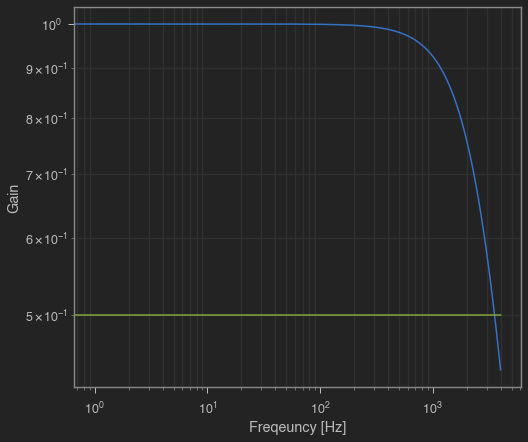

In [4]:
xdata = np.arange(0,4000,1)
ydata = memsResFct(xdata)
plt.loglog(xdata,ydata)
plt.loglog(xdata,np.array([0.5 for i in range(len(xdata))]))
plt.grid(which="minor")
plt.xlabel("Freqeuncy [Hz]")
plt.ylabel("Gain")

### 1.2 Transfer function of the interferometer
I failed reproducing.. this is made in mathematica:<br>
![title](InnalabsPic/aiRespFct.png)<br>

In [5]:
aiResFct = lambda f:  1/(1+(f)**2/1000)

This is a approximation. The first resonance happens at 100 Hz.

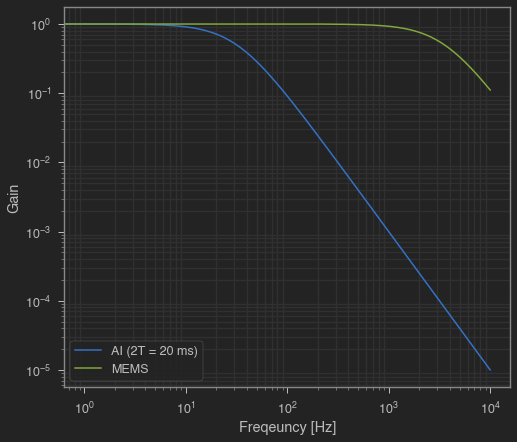

In [6]:
xdata = np.arange(0,10000,1)
yAIdata = aiResFct(xdata)
ymemsdata = memsResFct(xdata)
plt.loglog(xdata,yAIdata)
plt.loglog(xdata,ymemsdata)
plt.grid(which="minor")
plt.xlabel("Freqeuncy [Hz]")
plt.ylabel("Gain")
plt.legend(["AI (2T = 20 ms)","MEMS"])

### 1.3 PSD before and after filters
Let us now combine all the signal together.

The PSD of a MEMS accelerometer (collected on the boat) looks like the following:

In [7]:
from scipy import signal
innaLData = pd.read_csv("InnaLabs/motoron_grounded_0.csv")
innaLData["RealAcc"] = innaLData["v0"]*9.81/6000./0.0013

innaLData1 = pd.read_csv("InnaLabs/motoroff_floating_0.csv")[10000*100:]
innaLData1["RealAcc"] = innaLData1["v0"]*9.81/6000./0.0013

In [8]:
memsG = signal.periodogram(innaLData["RealAcc"], 10**4)
memsF = signal.periodogram(innaLData1["RealAcc"], 10**4)

Now, we need a electrical low pass filter which has a sharp cutoff. For the sake of the concept, lets go for ideal filters first.

In [9]:
idealLowF = lambda f:  1.0 if f <= 10 else 0.0
idealHighF = lambda f:  1.0 if f > 10 else (0.0)
yidlowFdata = np.array([idealLowF(i) for i in xdata])
yidhighFdata = np.array([idealHighF(i) for i in xdata])

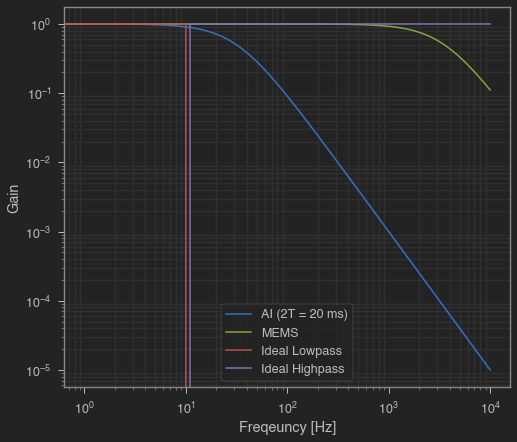

In [10]:
xdata = np.arange(0,10000,1)
yAIdata = aiResFct(xdata)
ymemsdata = memsResFct(xdata)

plt.loglog(xdata,yAIdata)
plt.loglog(xdata,ymemsdata)
plt.loglog(xdata,yidlowFdata)
plt.loglog(xdata,yidhighFdata)

plt.grid(which="minor")
plt.xlabel("Freqeuncy [Hz]")
plt.ylabel("Gain")
plt.legend(["AI (2T = 20 ms)","MEMS","Ideal Lowpass","Ideal Highpass"])

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


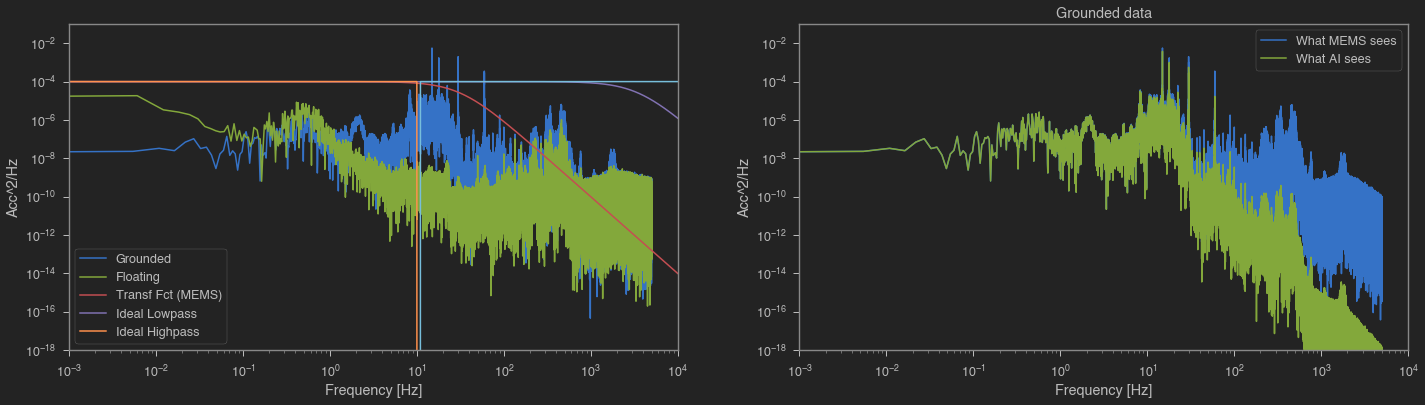

In [11]:
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(24,6))
ax[0].loglog(memsG[0],memsG[1])
ax[0].loglog(memsF[0],memsF[1])

ax[0].loglog(xdata,10**(-4)*yAIdata**2)
ax[0].loglog(xdata,10**(-4)*ymemsdata**2)
ax[0].loglog(xdata,10**(-4)*yidlowFdata**2)
ax[0].loglog(xdata,10**(-4)*yidhighFdata**2)

afmemsGnd = memsG[1]*(np.array([memsResFct(i) for i in memsG[0]])**2)
afaiGnd = memsG[1]*(np.array([aiResFct(i) for i in memsG[0]])**2)

ax[1].loglog(memsG[0],afmemsGnd)
ax[1].loglog(memsG[0],afaiGnd)

for i in range(2):
    ax[i].set_xlabel("Frequency [Hz]")
    ax[i].set_ylabel("Acc^2/Hz")
    ax[i].set_ylim([10**(-18),0.1])
    ax[i].set_xlim([0.001,10**4])
    
ax[1].set_title("Grounded data")
ax[0].legend(["Grounded","Floating","Transf Fct (MEMS)","Ideal Lowpass","Ideal Highpass"])
ax[1].legend(["What MEMS sees","What AI sees"])

This is very obvious. The MEMS sees just more acceleration than the interferometer. <br>
Let us now start introducing filters!

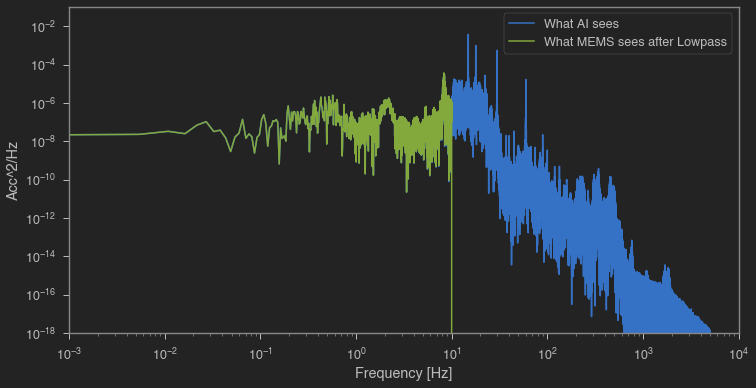

In [12]:
afmemsGnd = memsG[1]*(np.array([memsResFct(i) for i in memsG[0]])**2)
afaiGnd = memsG[1]*(np.array([aiResFct(i) for i in memsG[0]])**2)

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(12,6))
ax.loglog(memsG[0],afaiGnd)
ax.loglog(memsG[0],afmemsGnd*(np.array([idealLowF(i) for i in memsG[0]])**2))
#ax.loglog(memsG[0],afmemsGnd*(np.array([idealHighF(i) for i in memsG[0]])**2))
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("Acc^2/Hz")
ax.set_ylim([10**(-18),0.1])
ax.set_xlim([0.001,10**4])
ax.legend(["What AI sees","What MEMS sees after Lowpass"])

### 1.4 Introducing artificial bias drift
I have now some basic tools to look at the drift. Lets introduce some bias drift.<br>
These are the assumptions, which we will need to make:
- freqeuncy of the drift lower than the cutoff frequency of the low pass filter.
- 


In [13]:
def addBias(rawdata, biasf, amp):
    biasdata = [amp*np.sin(2*np.pi*biasf*t) for t in rawdata["Time"]]
    rawdata["wBias"] = rawdata["RealAcc"]+biasdata
    return rawdata

In [107]:
innaLData = addBias(innaLData,0.1,0.01)

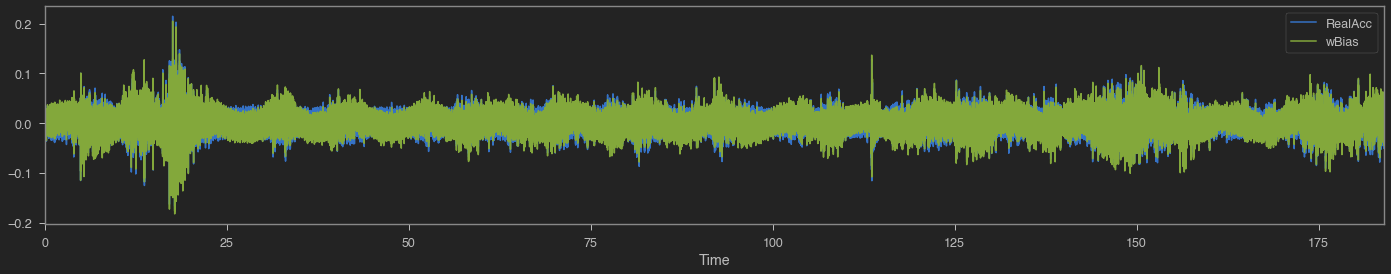

In [108]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(24,4))
innaLData.plot(x="Time",y="RealAcc",ax=ax)
innaLData.plot(x="Time",y="wBias",ax=ax)

Before applying the filter on the new data, lets be thorough and look at the PSD first.  

In [109]:
memswBiasPSD = signal.periodogram(innaLData["wBias"], 10**4)
memsPSD = signal.periodogram(innaLData["RealAcc"], 10**4)

In [110]:
afmemsPSD = memsPSD[1]*(np.array([memsResFct(i) for i in memsPSD[0]])**2)
afmemswBiasPSD = memswBiasPSD[1]*(np.array([memsResFct(i) for i in memswBiasPSD[0]])**2)

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


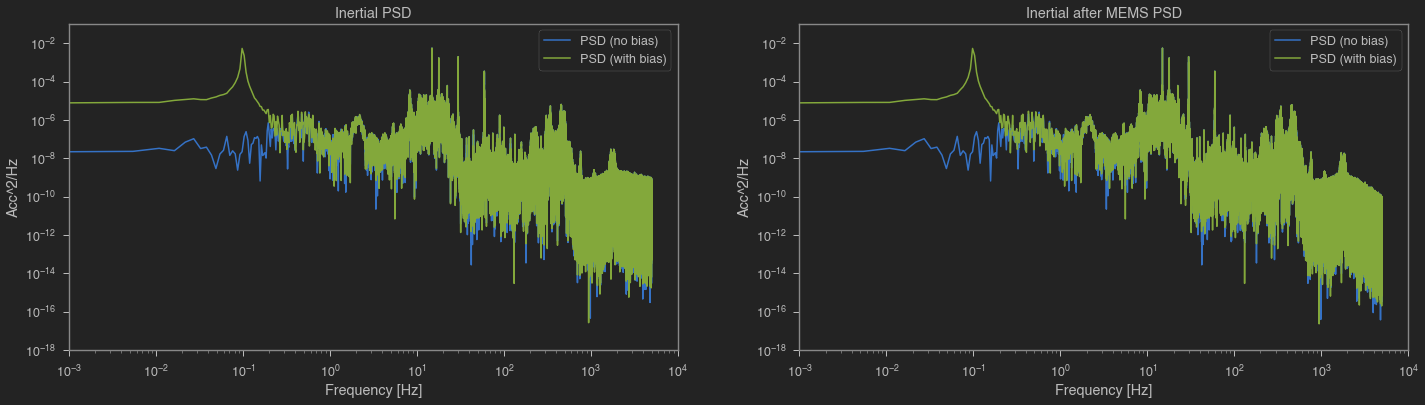

In [111]:
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(24,6))
ax[0].loglog(memsPSD[0],memsPSD[1])
ax[0].loglog(memswBiasPSD[0],memswBiasPSD[1])
ax[0].legend(["PSD (no bias)","PSD (with bias)"])
ax[0].set_title("Inertial PSD")

ax[1].loglog(memsPSD[0],afmemsPSD)
ax[1].loglog(memswBiasPSD[0],afmemswBiasPSD)
ax[1].legend(["PSD (no bias)","PSD (with bias)"])
ax[1].set_title("Inertial after MEMS PSD")


for i in range(2):
    ax[i].set_xlabel("Frequency [Hz]")
    ax[i].set_ylabel("Acc^2/Hz")
    ax[i].set_ylim([10**(-18),0.1])
    ax[i].set_xlim([0.001,10**4])

Now lets apply a filter on the data with bias and compare that with what AI sees.

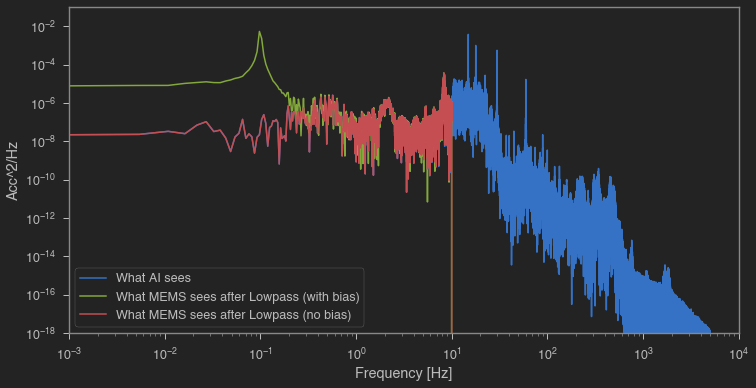

In [112]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(12,6))
ax.loglog(memsPSD[0],memsPSD[1]*(np.array([aiResFct(i) for i in memsPSD[0]])**2))
ax.loglog(memswBiasPSD[0],afmemswBiasPSD*(np.array([idealLowF(i) for i in memswBiasPSD[0]])**2))
ax.loglog(memsPSD[0],afmemsPSD*(np.array([idealLowF(i) for i in memsPSD[0]])**2))
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("Acc^2/Hz")
ax.set_ylim([10**(-18),0.1])
ax.set_xlim([0.001,10**4])
ax.legend(["What AI sees","What MEMS sees after Lowpass (with bias)","What MEMS sees after Lowpass (no bias)"])




This is a bit extreme. But demonstrates the idea. Now let us substract "What AI sees" from "What MEMS sees"!<br>
But how???<br>
- I can get the time series of the AI using temporal sensitivity function
- What about the low pass filter circuits for MEMS?
    - I can use fft and inverse fft

#### Prep AI 

In [113]:
def accSensFct(T,f):
    part1 = np.arange(1/(2*f),T,1/f)
    part2 = np.arange(T-1/(2*f),0,-1/f)
    values = np.concatenate((part1, part2), axis=0)
    return values

def getAtomAcc(T,f,realAccData,datalabel):
    tlist = []
    atomAcc = []
    for i in range(int((len(realAccData))/(2*T*f))):
        tempAcc = sum(realAccData[int(2*T*f*i):int(2*T*f*(i+1))]["RealAcc"]*accSensFct(T,f)/f)/(T**2)
        atomAcc.append(tempAcc)
        tlist.append(i*2*T+T)
    atomAccDF= pd.DataFrame({"Time":tlist, datalabel:atomAcc})
    return atomAccDF

In [114]:
newAIdata = getAtomAcc(0.01,10**4,innaLData,"2T=20ms")

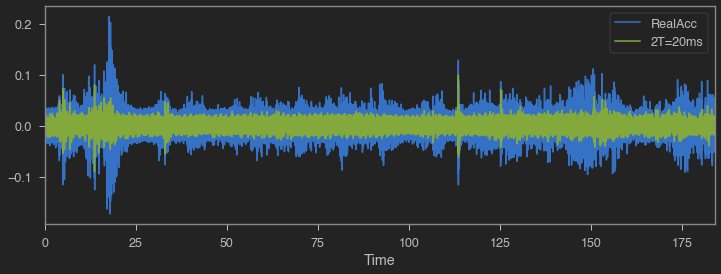

In [115]:
fig, ax = plt.subplots(ncols=1,nrows=1, figsize=(12,4))
innaLData.plot(x="Time", y="RealAcc",ax=ax)
newAIdata.plot(x="Time", y="2T=20ms",ax=ax)

#### Prep Low pass filter

In [116]:
fftMEMStime=np.fft.fft(innaLData["Time"])
fftMEMSdata=np.fft.fft(innaLData["RealAcc"])
fftMEMSwBiasdata=np.fft.fft(innaLData["wBias"])

In [117]:
ifftMEMSdata=np.fft.ifft(
    fftMEMSdata[0:int(len(innaLData)/2)]*np.array([idealLowF(i) for i in memsPSD[0][:-1]])
)

ifftMEMSwBiasdata=np.fft.ifft(
    fftMEMSwBiasdata[0:int(len(innaLData)/2)]*np.array([idealLowF(i) for i in memsPSD[0][:-1]])
)

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


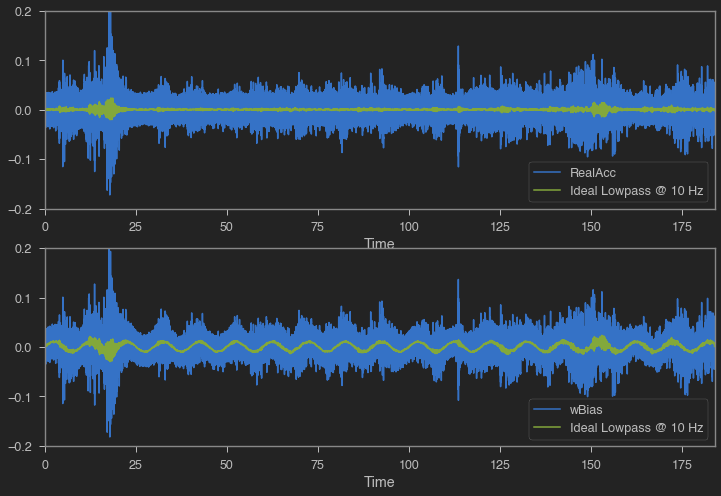

In [118]:
fig, ax = plt.subplots(ncols=1,nrows=2, figsize=(12,8))
innaLData.plot(x="Time", y="RealAcc",ax=ax[0])
ax[0].plot(innaLData["Time"][0::2],ifftMEMSdata)
ax[0].set_ylim([-0.2,0.2])
ax[0].legend(["RealAcc","Ideal Lowpass @ 10 Hz"])

innaLData.plot(x="Time", y="wBias",ax=ax[1])
ax[1].plot(innaLData["Time"][0::2],ifftMEMSwBiasdata)
ax[1].set_ylim([-0.2,0.2])
ax[1].legend(["wBias","Ideal Lowpass @ 10 Hz"])


This is good. At least it works until here.

### Measuring bias drift
Let us attempt our first bias drift measurement. (Ideal low pass filter and AI).<br>
We have said that 
- "RealAcc" is the real inertial acceleration
- "wBias" is added with sine bias drift.

In [119]:
newIFFTMEMSwBiasdata = np.array([ifftMEMSwBiasdata[100*i:(i+1)*100].mean().real for i in range(int(len(ifftMEMSwBiasdata)/100)) ])


ifftMEMSwBiasdataAI=np.fft.ifft(
    fftMEMSwBiasdata[0:int(len(innaLData)/2)]*np.array([aiResFct(i) for i in memsPSD[0][:-1]])
)
newIFFTMEMSwBiasdataAI = np.array([ifftMEMSwBiasdataAI[100*i:(i+1)*100].mean().real for i in range(int(len(ifftMEMSwBiasdataAI)/100)) ])



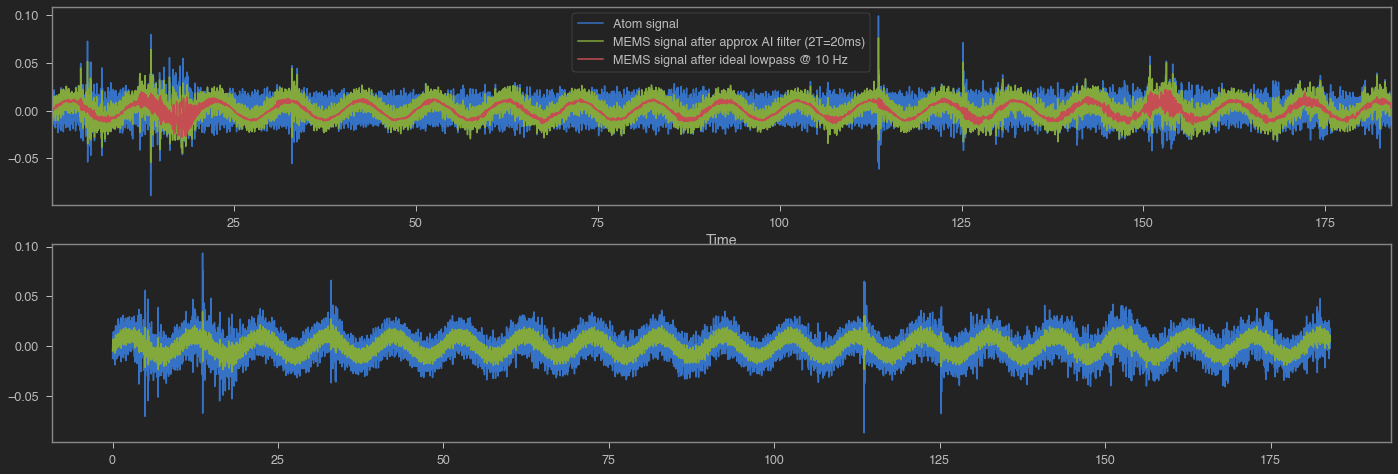

In [120]:
fig, ax = plt.subplots(ncols=1,nrows=2, figsize=(24,8))
newAIdata.plot(x="Time",y="2T=20ms",ax=ax[0])
ax[0].plot(newAIdata["Time"],newIFFTMEMSwBiasdataAI)
ax[0].plot(newAIdata["Time"],newIFFTMEMSwBiasdata)
ax[0].legend(["Atom signal", "MEMS signal after approx AI filter (2T=20ms)","MEMS signal after ideal lowpass @ 10 Hz"])


ax[1].plot(newAIdata["Time"],newIFFTMEMSwBiasdata-newAIdata["2T=20ms"])
ax[1].plot(newAIdata["Time"],newIFFTMEMSwBiasdataAI-newAIdata["2T=20ms"])

As we see, the problem lies in matching between the electric filter and the atom interferoemter. Let us now optimise this by 



The signal of AI is described by $\cos(k_\text{eff} a T^2 + 2k_\text{eff} v \Omega T^2)$ <br>

What we want to see is the relative dimensions between $a$ and $2v\Omega$.

On a boat, the vibration is around 2 mg rms, which is roughly about the dynamic range of a $2T=20\,$ms interferometer.

In [2]:
np.pi/(0.01**2*4*np.pi/0.00000078)

0.0019500000000000001

In [ ]:
# Bias scheme testing

realdata = boatDMU["Axis X Acceleration (g)"].values+np.array([0.1*np.sin(2*np.pi*i/100000) for i in range(len(realdata))])
biasadded = realdata+np.array([0.1*np.sin(2*np.pi*i/400000) for i in range(len(realdata))])

res0 =np.fft.ifft(np.fft.fft(realdata)[0:int(len(realdata)/2)])
res =np.fft.ifft(np.fft.fft(biasadded)[0:int(len(biasadded)/2)])
fc = 1/10000
HF = [i/fc/(1+(i/fc)) for i in range(1,int(len(biasadded)/2)+1)]
LF = [1/(1+(i/fc)) for i in range(0,int(len(biasadded)/2))]
resHF =np.fft.ifft(np.fft.fft(biasadded)[0:int(len(biasadded)/2)]*HF)
resLF =np.fft.ifft(np.fft.fft(biasadded)[0:int(len(biasadded)/2)]*LF)

testrealDF=pd.DataFrame({"Time":np.arange(len(res0)),"RealAcc":res0-resHF})

fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(24,20))
ax[0].plot(res0)
ax[0].plot(res)
ax[0].legend(["Raw data","Bias added"])

ax[1].plot(HF)
ax[1].plot(LF)
ax[1].legend(["High Pass filter","Low Pass filter"])

ax[2].plot(resHF)
ax[2].plot(resLF)
ax[2].legend(["HF bias data","LF bias data"])

ax[3].plot((res0-resHF-resLF))
ax[3].legend(["Raw data - HF bias data - LP bias data = bias"])

atomsign100 =getAtomAcc(100,1,testrealDF,"atomAcc")["atomAcc"].values
atomsign200 =getAtomAcc(200,1,testrealDF,"atomAcc")["atomAcc"].values
atomsign400 =getAtomAcc(400,1,testrealDF,"atomAcc")["atomAcc"].values
ax[4].scatter(x=np.arange(0,200*len(atomsign100),200),y=(atomsign100-resLF[0:-200:200]))
ax[4].scatter(x=np.arange(0,400*len(atomsign200),400),y=(atomsign200-resLF[0:-400:400]))
ax[4].scatter(x=np.arange(0,800*len(atomsign400),800),y=(atomsign400-resLF[0:-800:800]))
ax[4].legend(["2T=100 measured bias","2T=200 measured bias","2T=400 measured bias"])




## 2. Unstable scaling factor
$\eta$ can be calibrated apriori the start of a journey.

While maintaining the response function of the two sensors, we apply high pass filter to eliminate bias drift and low frequency inertial change. If scaling factor drifts, the vibration spread will become larger. This can be seen in the residuals in the AIvsMEMS plots. This probably sets the time scale of scaling factor correction around cutoff frequency of the high pass filter.

------
Questions:
1. What if the response functions after high pass filter are not the same?
2. Would high pass filter change the slow drift in the scalling factor?
3. Varify these in simulations first!

------


